# Seer Technical Interview: EEG Seizure Clasficiation using 1D CNN
This project uses the **BONN EEG Dataset** to train a **1D convolution neural network (CNN)** to distinguish **seizure (ictal) vs non seizure (interictal/healthy) EEG segments**. 
The Bonn dataset contains EEG recordings from healthy volunteers and epilepsy patients, with segments labeled as seizure (ictal) or non-seizure (comprised of interictal and healthy). The goal is to demonstrate a deep learning approach for seizure detection from single-channel EEG data.


### Dataset

**Bonn EEG dataset** contains **five sets (A–E)**, each with 100 single-channel EEG segments (~23.6 seconds each, 4097 samples per segment, 173.61 Hz sampling rate).  

| Set | Description | Seizure? |
|-----|------------|-----------|
| A   | Healthy, eyes open | No |
| B   | Healthy, eyes closed | No |
| C   | Interictal, non-epileptogenic | No |
| D   | Interictal, epileptogenic | No |
| E   | Seizure (ictal) | Yes |


### Challenges of BONN dataset
**Small dataset**: Relatively small dataset, with only 500 segments, 400 which are non-seizure and 100 which are seizure. To address this issue, data augmentation will be used. 

**Class imbalance**: Class imbalance with 4:1 non-seizure to seizure ratio. To address this issue during training, class weights are used. 

**No patient-level data**: BONN dataset has flat datasets containing healthy, interictal and seizure data. Therefore, we do not know which segments came from same patients, therefore training segments may have same patients as validation segments. This may result in over-optimistic performance metrics. Therefore, external validation on another dataset with unseen patient data would be required to get full understanding of dataset. 

### Goals

1. Load and preprocess EEG segments from all sets
2. Normalize and filter EEG signals
3. Build and train a **1D CNN** to classify seizure vs non-seizure segments
4. Evaluate model performance using loss curves, accuracy and confusion matrix
5. Apply data augmentation to address potential overfitting and limited sample size
6. External validation on CHB-MIT data set (if time permits)

### Links:
- [Bonn EEG Dataset](https://www.upf.edu/web/ntsa/downloads/-/asset_publisher/xvT6E4pczrBw/content/2001-indications-of-nonlinear-deterministic-and-finite-dimensional-structures-in-time-series-of-brain-electrical-activity-dependence-on-recording-regi)
- [Original Paper: Andrzejak et al., 2001](https://www.upf.edu/documents/229517819/232450661/Andrzejak-PhysicalReviewE2001.pdf/0e9a54b8-8993-b400-743e-4d64fa29fb63)


In [ ]:
## Import and load packages
import os
import numpy as np
import sys
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import random
import importlib
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report, f1_score, balanced_accuracy_score
from scipy.signal import butter, filtfilt


sys.path.append(os.path.abspath(".."))
import scripts
# import my functions
from scripts.preprocess import normalise_segments
from scripts.utils import plot_eeg_segment
from scripts.preprocess import load_and_preprocess
from scripts.train import train
from scripts.train import evaluate
from scripts.models import simple_EEG_MLP
from scripts.models import simple_EEG_CNN


## Load and Preprocess Data

**Filtering:** Butterworth filter to remove high frequency noise above 40 Hz
- Attenuates frquencies beyond cutoff of 40 Hz (e.g. may be caused by muscle artifacts, powerline noise), preserving key EEG rhythms without ripples


In [ ]:
## Load and preprocess data
base_path = os.path.abspath("../data")

# 0:non-seizure, 1: seizure 
folders = {
    "A": 0,
    "B": 0,
    "C": 0,
    "D": 0, 
    "E": 1
}

X, y = load_and_preprocess(base_path, folders)
X = np.array(X) 
print("EEG segments shape:", X.shape)
y = np.array(y)
print("Labels shape:", y.shape)

EEG segments shape: (500, 4097)
Labels shape: (500,)


## Visualise EEG segments

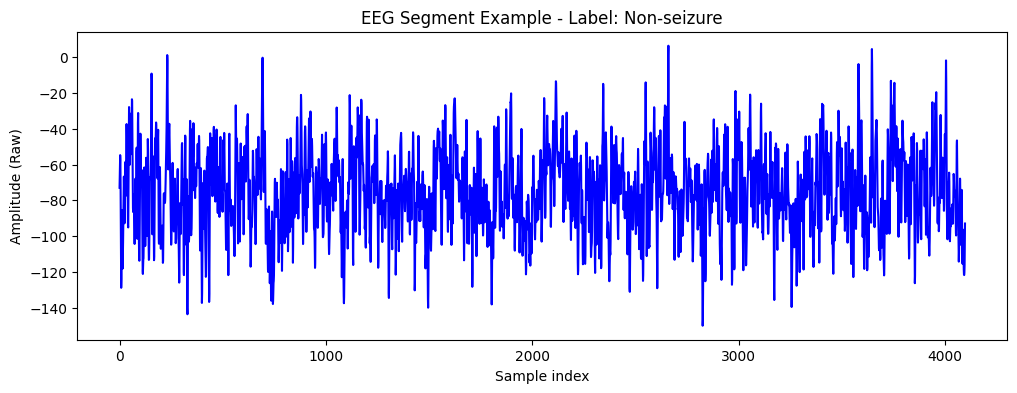

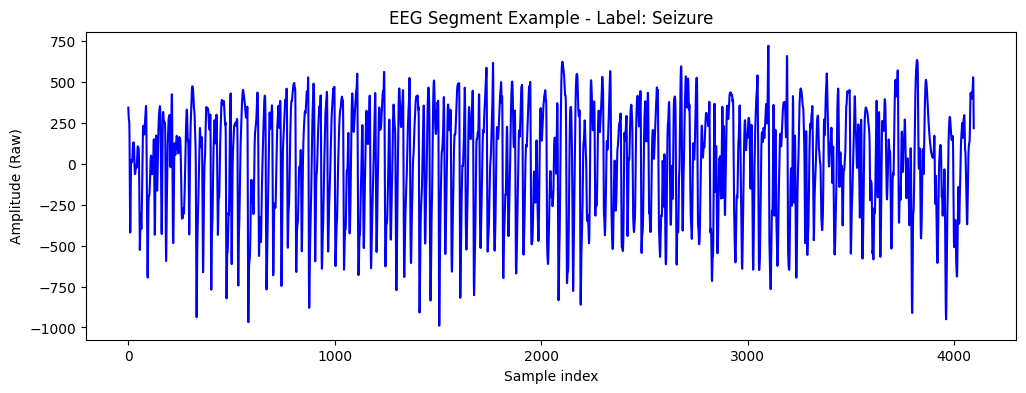

In [ ]:
# Visualise example of non-seizure 
segment = X[0]  
label = y[0]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)


# Visualise example of seizure 
segment = X[-1] 
label = y[-1]    
plot_eeg_segment(segment, label, num_samples = 4097, norm= False)

##  1D Convolutional Neural Network

### Overview
The 1D CNN applies convolutional filters along the temporal dimension of EEG signals.  
For EEG classification, it treats input as a **sequence of time samples**, allowing the model to learn local temporal patterns.

### Key components:
- **Convolutional layers:** Extract hierarchical features from raw signals  
- **Pooling layers:** Reduce temporal resolution while preserving key features  
- **Batch normalization:** Stabilizes training  
- **Dropout:** Prevents overfitting  
- **Fully connected layers:** Perform final binary classification  

### ✅ Pros
- Automatically learns temporal patterns without manual feature engineering  
- Faster and computationally efficient compared to recurrent networks (e.g., LSTMs)  
- Well suited for time series classification  

### ❌ Cons
- Multiple hyperparameters to tune (filter sizes, channels, pooling strategies)  
- Requires sufficient training data to learn robust features  

### 🎯 Motivation
1D CNNs capture temporal dynamics and patterns characteristic of seizure events while being computationally efficient for real-time applications.


### First trained a basic model: no data augmentation or hyperparameter tuning:

**Model Architecture:**
- Input: 1D time-series EEG signal (4097 samples)
- Architecture: Multi-layer 1D CNN with batch normalization and dropout
- Output: Binary classification (seizure vs non-seizure)
- Regularization: Dropout layers, L2 weight decay, batch normalization
- Loss function: CrossEntropyLoss with class weights to handle imbalance

**Training Strategy:**
- Validation method: 5-fold stratified cross-validation
- Optimizer: Adam with learning rate 1e-3
- Class weighting: Applied to loss function to address 1:4 class imbalance
- Early stopping: Implemented with patience=5 to prevent overfitting
- Normalization: Z-score normalization per fold (using training statistics only)

In [ ]:
## 1D CNN Model

class simple_EEG_CNN(nn.Module):
    def __init__(self, input_length=4097, dropout= 0.5):
        super(simple_EEG_CNN, self).__init__()

        # Conv1: Capture seizure spike patterns (70-200ms)
        # Kernel=25 → ~145ms at 173Hz
        self.conv1 = nn.Conv1d(in_channels=1, out_channels=16, kernel_size=25, stride=1, padding=12) 
        self.bn1 = nn.BatchNorm1d(16) # BatchNorm after conv1
        self.pool1 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout1 = nn.Dropout(dropout * 0.6)
        # After conv1+pool1: (batch, 16, 1024)

        # Conv2: Capture medium-term patterns (300-500ms)
        # Kernel=15 → ~350ms in the pooled space
        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=15, stride=1, padding=7)
        self.bn2 = nn.BatchNorm1d(32) # BatchNorm after conv2
        self.pool2 = nn.MaxPool1d(kernel_size=4, stride=4)
        self.dropout2 = nn.Dropout(dropout * 0.8)  
        # After conv3+pool3: (batch, 32, 256)

        # Conv3: Capture long-term evolution patterns
        self.conv3 = nn.Conv1d(in_channels=32, out_channels=64, kernel_size=7, stride=1, padding=3)
        self.bn3 = nn.BatchNorm1d(64) # BatchNorm after conv3
        self.pool3 = nn.MaxPool1d(kernel_size=4, stride=4)
        # after conv 3 (batch, 64, 64)
        
        # Dropout for regularization
        self.dropout3 = nn.Dropout(dropout)

        # global pooling
        self.global_pool = nn.AdaptiveAvgPool1d(1)

        self.fc1 = nn.Linear(64, 64)  
        self.dropout_fc = nn.Dropout(0.5)
        self.fc2 = nn.Linear(64, 2)

    def forward(self, x):
        if x.dim() == 2:
            x = x.unsqueeze(1)
            
        # Conv block 1
        x = self.conv1(x)
        x = self.bn1(x)
        x = F.relu(x)
        x = self.pool1(x)
        x = self.dropout1(x)  
        
        # Conv block 2
        x = self.conv2(x)
        x = self.bn2(x)
        x = F.relu(x)
        x = self.pool2(x)
        x = self.dropout2(x)  
        
        # Conv block 3
        x = self.conv3(x)
        x = self.bn3(x)
        x = F.relu(x)
        x = self.pool3(x)
        x = self.dropout3(x)  
        
        # Global pooling and classifier
        x = self.global_pool(x)
        x = x.view(x.size(0), -1)
        
        x = self.fc1(x)
        x = F.relu(x)
        x = self.dropout_fc(x)
        x = self.fc2(x)
        
        return x


In [116]:
importlib.reload(scripts.CV)
from scripts.CV import train_with_kfold_cv
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
fold_results = train_with_kfold_cv(
    X, 
    y, 
    simple_EEG_CNN,
    n_splits=5, 
    max_epochs=25, 
    batch_size=32, 
    device=device,
    patience= 5,
    min_delta= 0.001,
    model_kwargs={'input_length': 4097}
)

Starting 5-Fold Cross-Validation

FOLD 1/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.0894/0.9675 | Val: 0.0647/0.9800 | Patience: 0/5
  Epoch 20/25 | Train: 0.0676/0.9900 | Val: 0.0505/0.9800 | Patience: 2/5
  Fold 1 Summary:
    Best Val Acc: 0.9900 at epoch 22
    Total epochs: 25

FOLD 2/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.0849/0.9775 | Val: 0.0871/0.9800 | Patience: 1/5
  Early stopping at epoch 14
  Fold 2 Summary:
    Best Val Acc: 0.9900 at epoch 9
    Total epochs: 14

FOLD 3/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.0764/0.9775 | Val: 0.1127/0.9600 | Patience: 0/5
  Early stopping at epoch 16
  Fold 3 Summary:
    Best Val Acc: 0.9700 at epoch 11
    Total epochs: 16

FOLD 4/5
------------------------------------------------------------
  Epoch 10/25 | Train: 0.1177/0.9750 | Val: 0.0491/0.9900 | Patience: 0/5
  Epoch 20/25 | Train: 0.147

### Evaluating Results

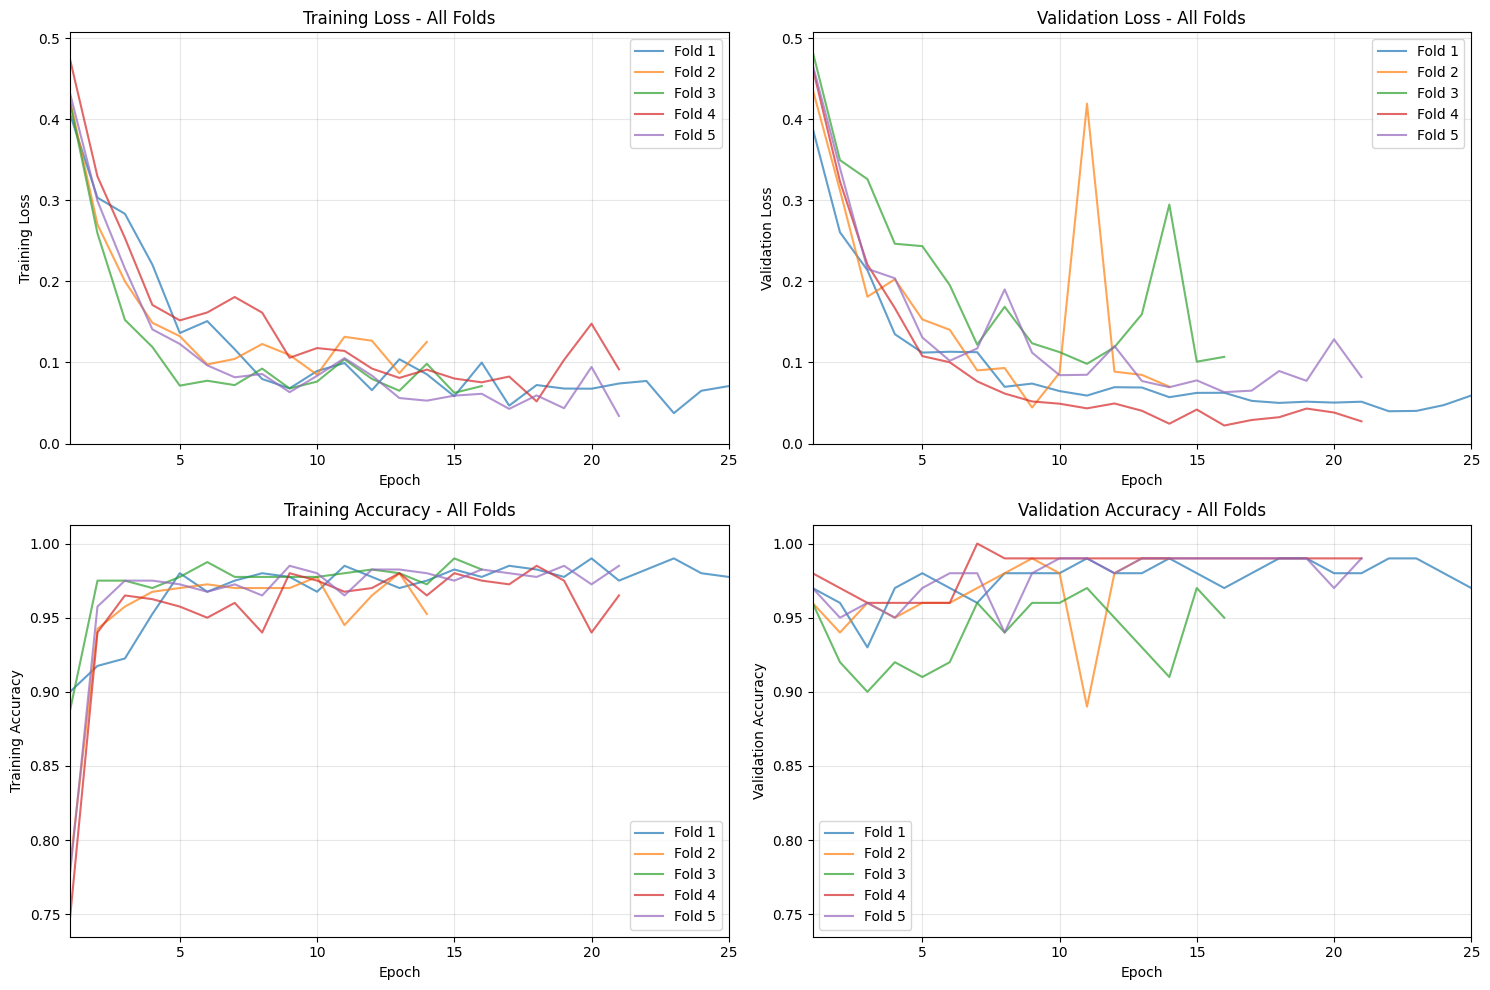

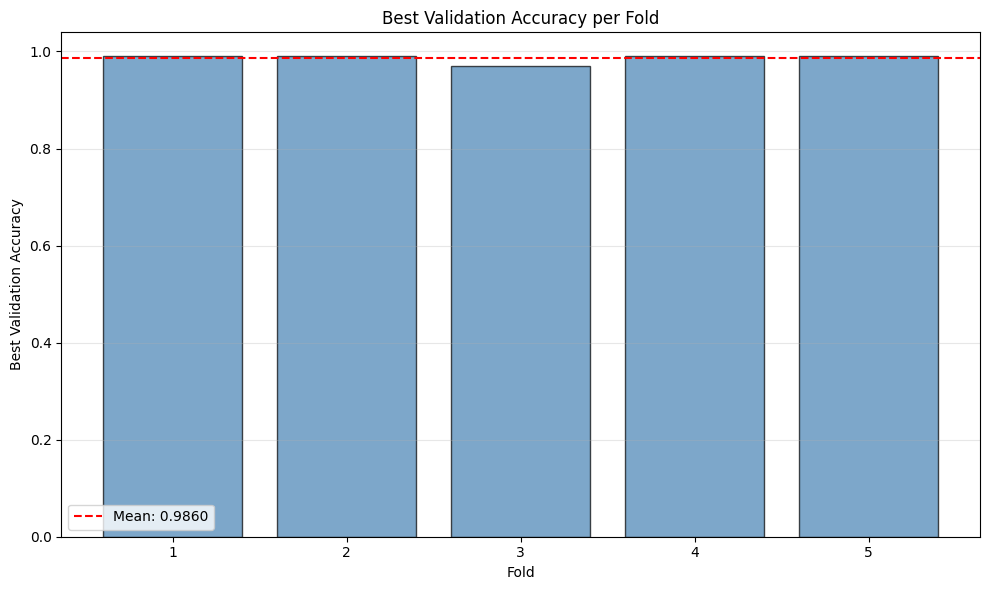

Mean accuracy: 0.9860
Std accuracy: 0.0080
Best fold: 1
Best accuracy: 0.9900


In [117]:
importlib.reload(scripts.utils)
from scripts.utils import plot_kfold_results
plot_kfold_results(fold_results, 5)

print(f"Mean accuracy: {np.mean(fold_results['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(fold_results['best_val_accs']):.4f}")

# 6. Get best fold
best_fold_idx = np.argmax(fold_results['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {fold_results['best_val_accs'][best_fold_idx]:.4f}")

Calculating metrics from saved models...

Fold 1: Acc=0.9900 | Bal_Acc=0.9934 | F1=0.9796 | Prec=0.9600 | Rec=1.0000
Fold 2: Acc=0.9900 | Bal_Acc=0.9722 | F1=0.9714 | Prec=1.0000 | Rec=0.9444
Fold 3: Acc=0.9700 | Bal_Acc=0.9585 | F1=0.9143 | Prec=0.8889 | Rec=0.9412
Fold 4: Acc=0.9900 | Bal_Acc=0.9938 | F1=0.9756 | Prec=0.9524 | Rec=1.0000
Fold 5: Acc=0.9900 | Bal_Acc=0.9762 | F1=0.9756 | Prec=1.0000 | Rec=0.9524

KEY METRICS SUMMARY

Metric               Mean ± Std           Range               
------------------------------------------------------------
Accuracy             0.9860 ± 0.0080     [0.9700, 0.9900]
Balanced Accuracy    0.9788 ± 0.0134     [0.9585, 0.9938]
F1 Score             0.9633 ± 0.0246     [0.9143, 0.9796]
Precision            0.9603 ± 0.0408     [0.8889, 1.0000]
Recall (Sensitivity) 0.9676 ± 0.0267     [0.9412, 1.0000]

Average Confusion Matrix:
  TN (Non-Seizure correct): 79.2
  FP (False alarm):         0.8
  FN (Missed seizure):      0.6  ⚠️ Most critical!
  TP

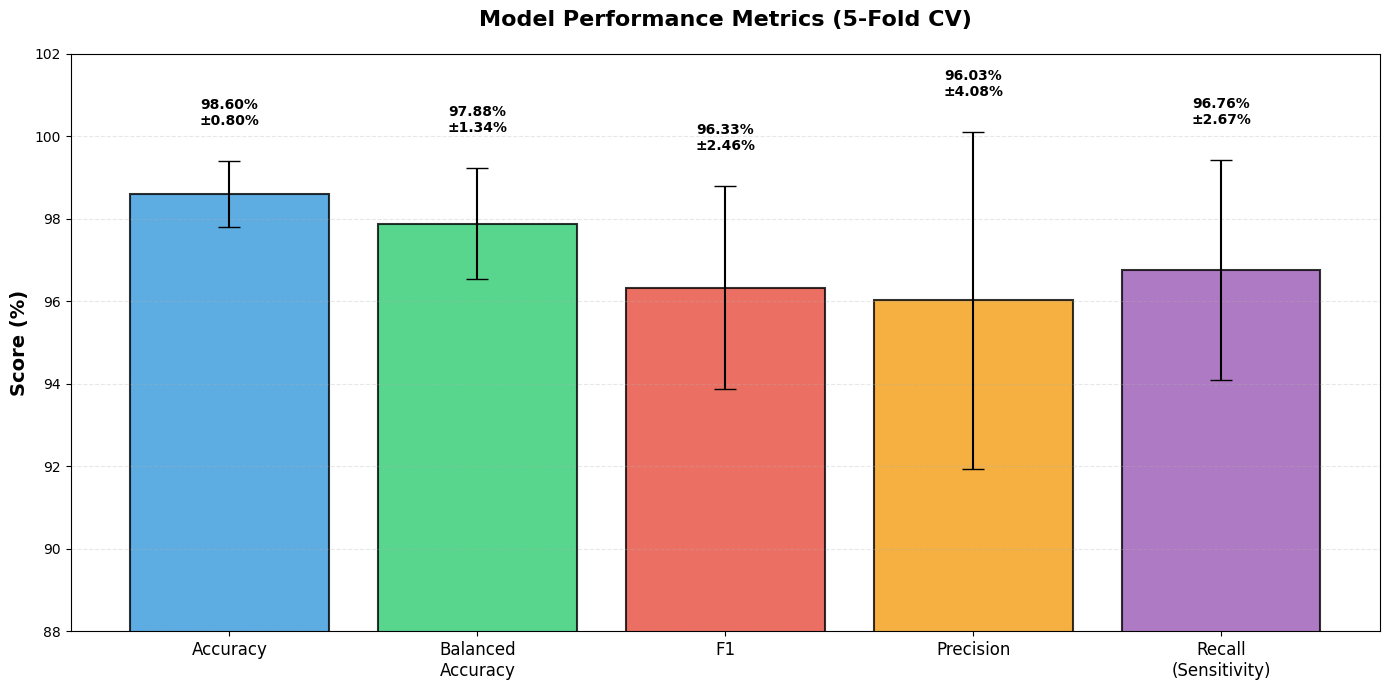

In [118]:
importlib.reload(scripts.CV)
from scripts.CV import calculate_metrics_from_saved_models, print_quick_summary, plot_metrics_comparison        
# Calculate comprehensive metrics
metrics = calculate_metrics_from_saved_models(X, y, simple_EEG_CNN, n_splits=5, device= device)
print_quick_summary(metrics)
plot_metrics_comparison(metrics)

### First model writeup

- Seeing high performance metrics: may be indicative of overlapping patients and overoptimistic?
- Seeing variability in validation loss and accuracy compared to training: may be indicative of overfitting
- Next steps: add data-augmentation, improve generalisability of model

## Second 1D CNN Model: Data Augmentation and Hyperparameter tuning

- What is data augmentation?
- Why is it useful?
- How will I implement

Original seizure samples: 100
Generating 300 augmented samples...
Final augmented seizure count: 400

Balanced dataset:
  Seizures: 400
  Non-seizures: 400


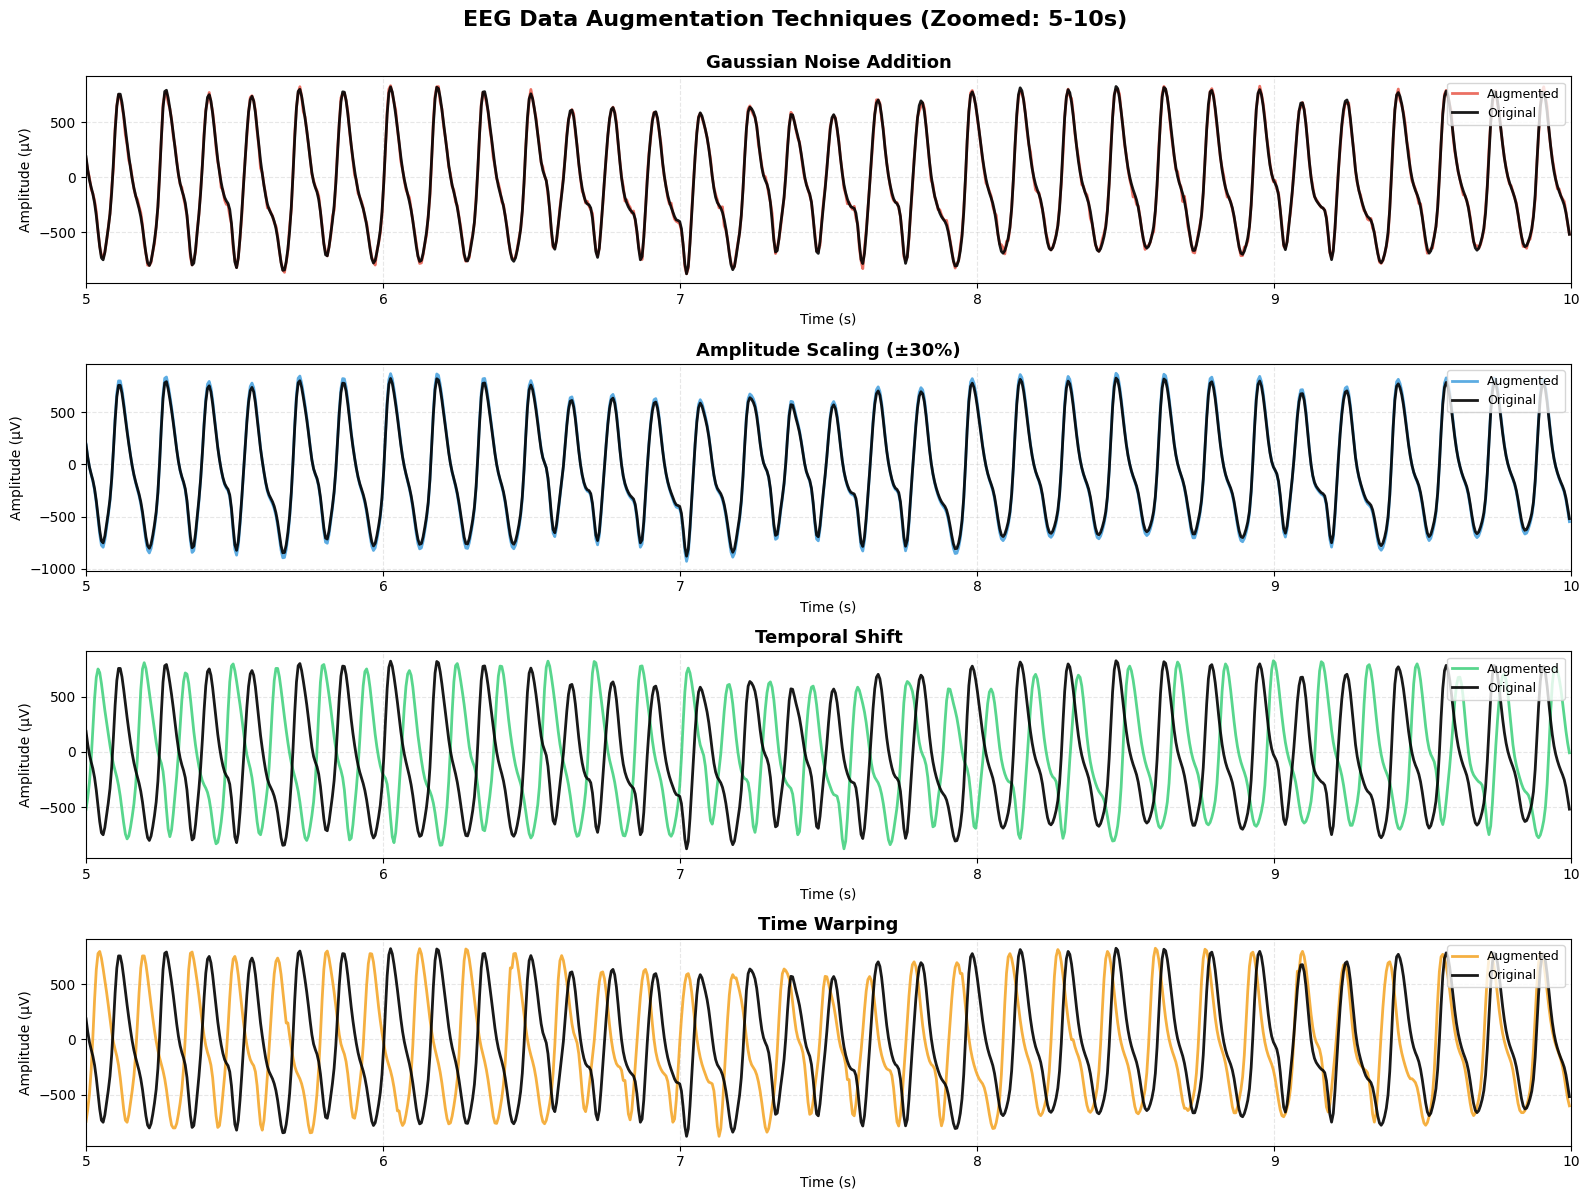

In [75]:
importlib.reload(scripts.augmentation)
from scripts.augmentation import create_augmented_dataset, visualize_augmentation_comparison
# Usage:
# Separate your data
X_seizure = X[y == 1]
X_non_seizure = X[y == 0]
y_seizure = y[y == 1]
y_non_seizure = y[y == 0]

# Augment seizures to match non-seizures (or get closer)
X_seizure_aug, y_seizure_aug = create_augmented_dataset(
    X_seizure, y_seizure, 
    target_count=400,  # Match non-seizure count
    aug_methods=['noise', 'scale', 'shift']
)

# Combine everything
X_balanced = np.vstack([X_seizure_aug, X_non_seizure])
y_balanced = np.hstack([y_seizure_aug, y_non_seizure])

# Shuffle
shuffle_idx = np.random.permutation(len(X_balanced))
X_balanced = X_balanced[shuffle_idx]
y_balanced = y_balanced[shuffle_idx]

print(f"\nBalanced dataset:")
print(f"  Seizures: {(y_balanced == 1).sum()}")
print(f"  Non-seizures: {(y_balanced == 0).sum()}")


visualize_augmentation_comparison(X_seizure, sample_idx=0)

In [120]:
importlib.reload(scripts.augmentation)

from scripts.augmentation import train_with_kfold_cv_augmented
cv_results_with_aug = train_with_kfold_cv_augmented(
    X, y,
    model_class=simple_EEG_CNN,
    n_splits=5,
    max_epochs=50,
    batch_size=32,
    device=device,
    use_augmentation=True,  # Use augmentation
    aug_methods=['noise', 'scale'],
    tune_hyperparams= True, n_tuning_trials = 3
)


Starting 5-Fold Cross-Validation
Using NESTED CV with hyperparameter tuning (3 trials/fold)
Using augmentation: ['noise', 'scale']

FOLD 1/5
------------------------------------------------------------
  Tuning hyperparameters (3 random trials)...
    Trial 1/3: LR=1e-03, BS=16, Dropout=0.40, WD=1e-05 → Val Acc: 0.9875
    Trial 2/3: LR=1e-03, BS=16, Dropout=0.30, WD=1e-05 → Val Acc: 0.9875
    Trial 3/3: LR=5e-04, BS=32, Dropout=0.50, WD=1e-05 → Val Acc: 0.9875
  → Best params: LR=1e-03, BS=16, Dropout=0.40, WD=1e-05 (Tuning Val Acc: 0.9875)
  Before augmentation: 76 seizures, 324 non-seizures
Original seizure samples: 76
Generating 74 augmented samples...
Final augmented seizure count: 150
  After augmentation: 150 seizures, 324 non-seizures
  Epoch 10/50 | Train: 0.0802/0.9810 | Val: 0.0575/0.9800 | Patience: 4/5
  Early stopping at epoch 11
  Fold 1 Summary:
    Best Val Acc: 0.9800 at epoch 6
    Total epochs: 11

FOLD 2/5
----------------------------------------------------------

Calculating metrics from saved models...

Fold 1: Acc=0.9800 | Bal_Acc=0.9868 | F1=0.9600 | Prec=0.9231 | Rec=1.0000
Fold 2: Acc=0.9900 | Bal_Acc=0.9939 | F1=0.9730 | Prec=0.9474 | Rec=1.0000
Fold 3: Acc=0.9900 | Bal_Acc=0.9706 | F1=0.9697 | Prec=1.0000 | Rec=0.9412
Fold 4: Acc=0.9900 | Bal_Acc=0.9938 | F1=0.9756 | Prec=0.9524 | Rec=1.0000
Fold 5: Acc=0.9900 | Bal_Acc=0.9762 | F1=0.9756 | Prec=1.0000 | Rec=0.9524


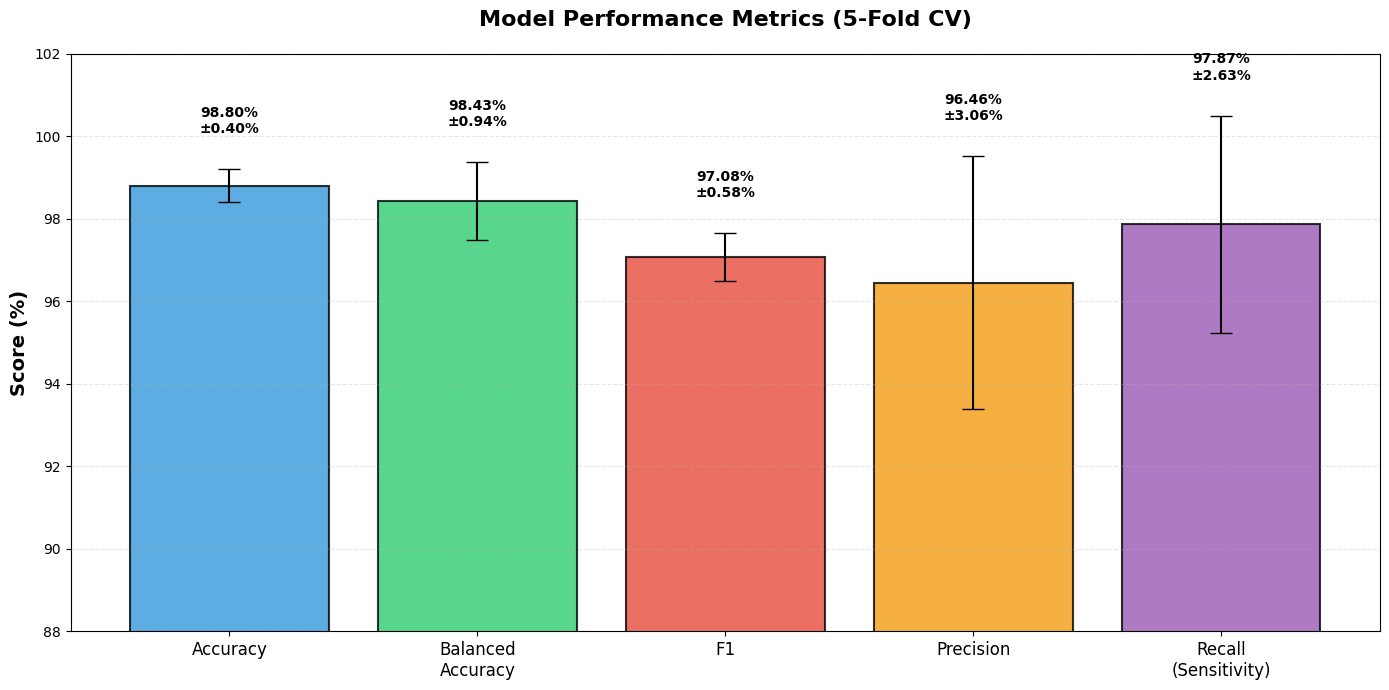

In [123]:
# Calculate metrics
metrics_with_aug = calculate_metrics_from_saved_models(
    X, y, simple_EEG_CNN, n_splits=5, device=device
)
plot_metrics_comparison(metrics_with_aug)

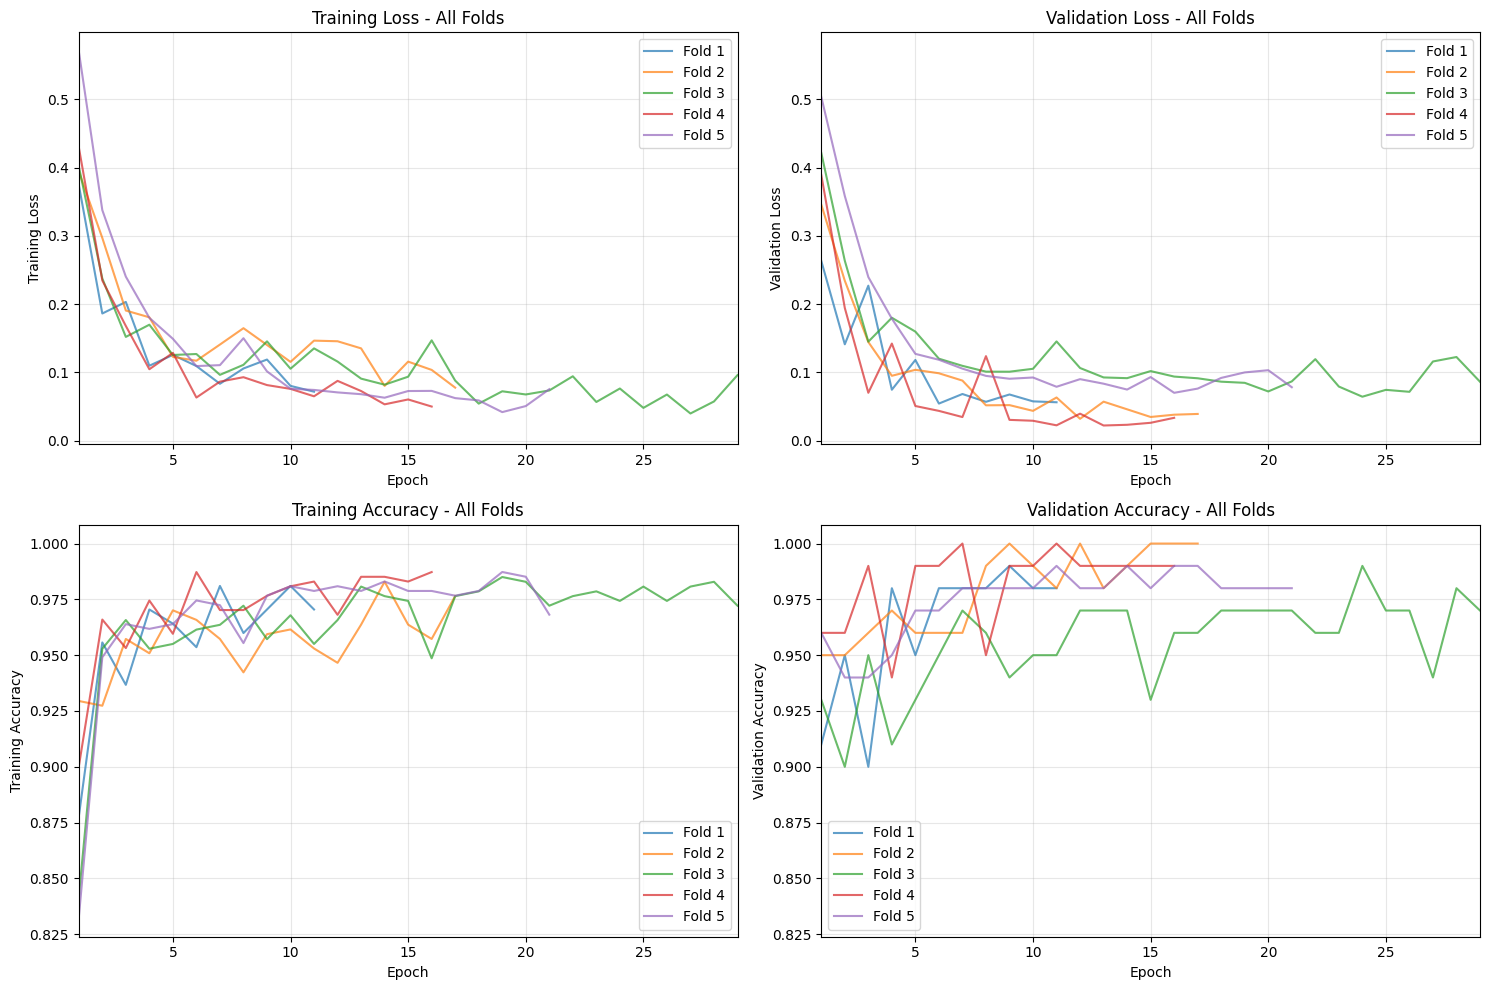

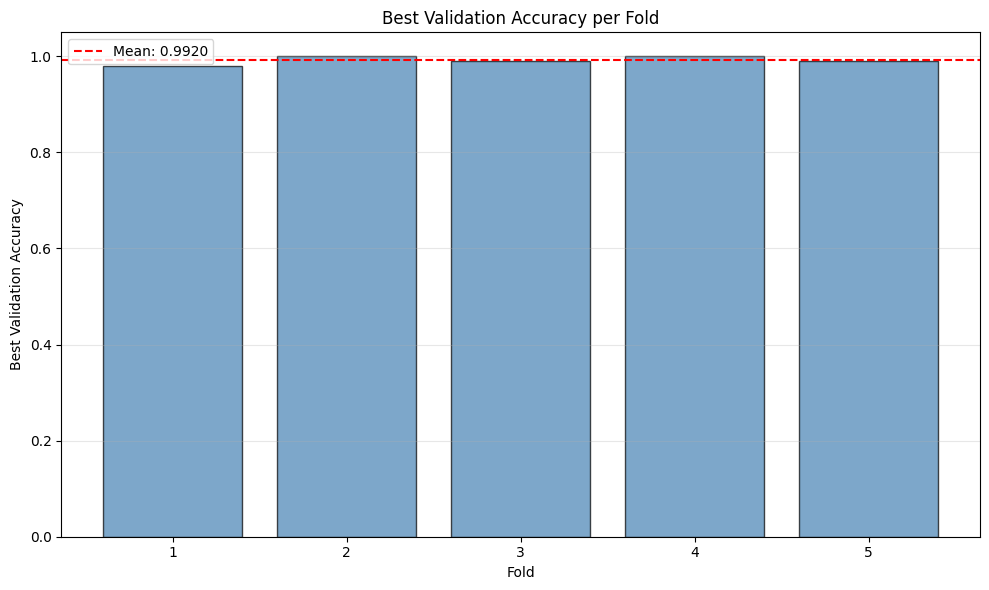

Mean accuracy: 0.9920
Std accuracy: 0.0075
Best fold: 2
Best accuracy: 1.0000


In [124]:
importlib.reload(scripts.utils)
from scripts.utils import plot_kfold_results
plot_kfold_results(cv_results_with_aug , 5)

print(f"Mean accuracy: {np.mean(cv_results_with_aug ['best_val_accs']):.4f}")
print(f"Std accuracy: {np.std(cv_results_with_aug ['best_val_accs']):.4f}")

# 6. Get best fold
best_fold_idx = np.argmax(cv_results_with_aug ['best_val_accs'])
print(f"Best fold: {best_fold_idx + 1}")
print(f"Best accuracy: {cv_results_with_aug ['best_val_accs'][best_fold_idx]:.4f}")

## CHB-MIT EXAMPLES

In [138]:
# patient 1: 15 (Seizures), 16 (seizures), 8 (no seizures)
import mne
file_path = os.path.abspath('../data/chb01_15.edf')

# Check if file exists before trying to read
if os.path.exists(file_path):
    print(f"✓ Found file: {file_path}")
    raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)
else:
    print(f"✗ File not found: {file_path}")

print(raw)
# Get data
data, times = raw[:, :]  # (n_channels, n_timepoints)

print(f"Shape: {data.shape}")
print(f"Channels: {raw.ch_names}")
print(f"Duration: {times[-1]:.1f} seconds")





✓ Found file: /Users/nataliemarryatt/Epilepsy_project/data/chb01_15.edf
<RawEDF | chb01_15.edf, 23 x 921600 (3600.0 s), ~161.7 MiB, data loaded>
Shape: (23, 921600)
Channels: ['FP1-F7', 'F7-T7', 'T7-P7', 'P7-O1', 'FP1-F3', 'F3-C3', 'C3-P3', 'P3-O1', 'FP2-F4', 'F4-C4', 'C4-P4', 'P4-O2', 'FP2-F8', 'F8-T8', 'T8-P8-0', 'P8-O2', 'FZ-CZ', 'CZ-PZ', 'P7-T7', 'T7-FT9', 'FT9-FT10', 'FT10-T8', 'T8-P8-1']
Duration: 3600.0 seconds


/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1629101224.py:8: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(file_path, preload=True, verbose=False)


In [153]:
"""
COMPLETE CODE: Extract Single Channel from Individual CHB-MIT Files
====================================================================

Fixed and complete implementation for file-by-file extraction
"""

import numpy as np
import os
import mne
from pathlib import Path

# =============================================================================
# CONFIGURATION
# =============================================================================

# File to process
FILE_NAME = 'chb01_16.edf'
DATA_DIR = '../data'

# Parameters
WINDOW_SIZE = 23.6  # seconds (match Kaggle)
OVERLAP = 0.0       # no overlap (match Kaggle)

# Preferred channels (in priority order - temporal first)
PREFERRED_CHANNELS = [
    'F7-T7', 'F8-T8',      # Best: pure temporal
    'FP1-F7', 'FP2-F8',    # Good: frontal-temporal (commonly available)
    'T7-P7', 'T8-P8',      # Good: temporal-parietal
    'FT9-FT10',            # Temporal
    'C3-P3', 'C4-P4'       # Backup: central-parietal
]

# =============================================================================
# HELPER FUNCTIONS
# =============================================================================

# QUICK FIX - Replace your read_seizure_annotations function with this:

def read_seizure_annotations(seizure_file_path):
    """Read CHB-MIT seizure annotation file with proper encoding"""
    if not os.path.exists(seizure_file_path):
        print(f"  No seizure file found")
        return []
    
    seizures = []
    
    # Try different encodings (CHB-MIT files may use latin-1 or iso-8859-1)
    for encoding in ['utf-8', 'latin-1', 'iso-8859-1', 'cp1252']:
        try:
            with open(seizure_file_path, 'r', encoding=encoding) as f:
                lines = f.readlines()
            # If successful, parse the lines
            i = 0
            while i < len(lines):
                line = lines[i].strip()
                
                if 'Seizure' in line and 'Start Time' in line:
                    try:
                        start_time = int(line.split(':')[-1].strip().split()[0])
                        i += 1
                        if i < len(lines) and 'End Time' in lines[i]:
                            end_time = int(lines[i].split(':')[-1].strip().split()[0])
                            seizures.append((start_time, end_time))
                            print(f"  Found seizure: {start_time}s - {end_time}s")
                    except (ValueError, IndexError):
                        pass
                i += 1
            
            return seizures  # Successfully read and parsed
            
        except UnicodeDecodeError:
            continue  # Try next encoding
    
    print(f"  Warning: Could not read file with any encoding")
    return []

def select_best_channel(available_channels, preferred_channels):
    """
    Select best channel from available channels based on priority
    
    Args:
        available_channels: List of channel names in file
        preferred_channels: List of preferred channels in priority order
        
    Returns:
        Selected channel name
    """
    # Try each preferred channel in order
    for preferred in preferred_channels:
        if preferred in available_channels:
            return preferred
    
    # If none of the preferred channels exist, pick first temporal-related
    for ch in available_channels:
        if any(temporal in ch for temporal in ['T7', 'T8', 'T3', 'T4', 'F7', 'F8', 'FT']):
            print(f"  Warning: Using {ch} (not in preferred list, but is temporal)")
            return ch
    
    # Last resort: use first available channel
    print(f"  Warning: No temporal channel found, using first available: {available_channels[0]}")
    return available_channels[0]


def check_overlap(win_start, win_end, seizure_list):
    """
    Check if a window overlaps with any seizure
    
    Args:
        win_start: Window start time (seconds)
        win_end: Window end time (seconds)
        seizure_list: List of (start, end) seizure times
        
    Returns:
        True if window overlaps with any seizure, False otherwise
    """
    for sz_start, sz_end in seizure_list:
        # Overlap condition: window starts before seizure ends AND window ends after seizure starts
        if win_start < sz_end and win_end > sz_start:
            return True
    return False


# =============================================================================
# MAIN EXTRACTION FUNCTION
# =============================================================================

def extract_segments_from_file(file_path, data_dir, window_size=23.6, overlap=0.0,
                                preferred_channels=None, specific_channel=None):
    """
    Extract single-channel segments from one CHB-MIT EDF file
    
    Args:
        file_path: Name of EDF file (e.g., 'chb01_15.edf')
        data_dir: Directory containing the file
        window_size: Window size in seconds
        overlap: Overlap fraction (0.0 = no overlap)
        preferred_channels: List of preferred channels in priority order
        specific_channel: Specific channel to use (overrides auto-selection)
        
    Returns:
        X: numpy array (n_windows, n_samples) - single channel data
        y: numpy array (n_windows,) - labels (1=seizure, 0=non-seizure)
        metadata: dict with extraction info
    """
    
    print("="*70)
    print(f"EXTRACTING SEGMENTS FROM: {file_path}")
    print("="*70)
    
    # Construct full paths
    edf_file = os.path.join(data_dir, file_path)
    seizure_file = edf_file + '.seizures'
    
    # Check if file exists
    if not os.path.exists(edf_file):
        print(f"ERROR: File not found: {edf_file}")
        return None, None, None
    
    # 1. Read EDF file
    print(f"\n1. Reading EDF file...")
    try:
        raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
    except Exception as e:
        print(f"ERROR: Could not read EDF file: {e}")
        return None, None, None
    
    print(f"   ✓ File loaded")
    print(f"   Duration: {raw.times[-1]:.1f} seconds ({raw.times[-1]/60:.1f} minutes)")
    print(f"   Sampling rate: {raw.info['sfreq']} Hz")
    print(f"   Available channels: {len(raw.ch_names)}")
    
    # 2. Select channel
    print(f"\n2. Selecting channel...")
    
    if specific_channel is not None:
        if specific_channel in raw.ch_names:
            selected_channel = specific_channel
            print(f"   ✓ Using specified channel: {selected_channel}")
        else:
            print(f"   Warning: Specified channel '{specific_channel}' not found")
            print(f"   Falling back to auto-selection...")
            selected_channel = select_best_channel(raw.ch_names, preferred_channels)
    else:
        selected_channel = select_best_channel(raw.ch_names, preferred_channels)
        print(f"   ✓ Auto-selected channel: {selected_channel}")
    
    # Get single channel data
    channel_idx = raw.ch_names.index(selected_channel)
    data = raw.get_data()[channel_idx, :]  # 1D array: (n_timepoints,)
    times = raw.times
    sfreq = raw.info['sfreq']
    
    print(f"   Data shape: {data.shape}")
    
    # 3. Read seizure annotations
    print(f"\n3. Reading seizure annotations...")
    seizures = read_seizure_annotations(seizure_file)
    print(f"   ✓ Found {len(seizures)} seizure(s)")
    
    # 4. Extract windows
    print(f"\n4. Extracting windows...")
    print(f"   Window size: {window_size}s")
    print(f"   Overlap: {overlap*100:.0f}%")
    
    window_samples = int(window_size * sfreq)
    stride_samples = int(window_samples * (1 - overlap))
    
    print(f"   Window samples: {window_samples}")
    print(f"   Stride samples: {stride_samples}")
    
    windows = []
    labels = []
    window_times = []
    
    # Calculate how many windows fit
    total_samples = len(data)
    start_sample = 0
    
    while start_sample + window_samples <= total_samples:
        end_sample = start_sample + window_samples
        
        # Calculate window time
        win_start_time = start_sample / sfreq
        win_end_time = end_sample / sfreq
        
        # Extract window
        window_data = data[start_sample:end_sample]
        
        # Determine label
        is_seizure = check_overlap(win_start_time, win_end_time, seizures)
        label = 1 if is_seizure else 0
        
        windows.append(window_data)
        labels.append(label)
        window_times.append((win_start_time, win_end_time))
        
        # Move to next window
        start_sample += stride_samples
    
    # Convert to numpy arrays
    X = np.array(windows)  # Shape: (n_windows, n_samples)
    y = np.array(labels)
    
    # Summary
    n_seizure = np.sum(y == 1)
    n_non_seizure = np.sum(y == 0)
    
    print(f"\n5. Extraction complete!")
    print(f"   ✓ Total windows: {len(y)}")
    print(f"   ✓ Seizure windows: {n_seizure} ({n_seizure/len(y)*100:.1f}%)")
    print(f"   ✓ Non-seizure windows: {n_non_seizure} ({n_non_seizure/len(y)*100:.1f}%)")
    print(f"   ✓ Data shape: {X.shape}")
    print(f"      (n_windows={X.shape[0]}, n_samples={X.shape[1]})")
    
    # Create metadata
    metadata = {
        'file': file_path,
        'channel': selected_channel,
        'sfreq': sfreq,
        'window_size': window_size,
        'overlap': overlap,
        'n_windows': len(y),
        'n_seizure': n_seizure,
        'n_non_seizure': n_non_seizure,
        'seizures': seizures,
        'window_times': window_times
    }
    
    return X, y, metadata


# =============================================================================
# RUN EXTRACTION
# =============================================================================

if __name__ == "__main__":
    
    print("\\n" + "="*70)
    print("CHB-MIT SINGLE-CHANNEL SEGMENT EXTRACTION")
    print("="*70)
    
    # Extract segments
    X, y, metadata = extract_segments_from_file(
        file_path=FILE_NAME,
        data_dir=DATA_DIR,
        window_size=WINDOW_SIZE,
        overlap=OVERLAP,
        preferred_channels=PREFERRED_CHANNELS,
        specific_channel=None  # or specify: 'FP1-F7'
    )
    
    if X is not None:
        print("\\n" + "="*70)
        print("EXTRACTION SUCCESSFUL!")
        print("="*70)
        
        print(f"\\nData ready for model:")
        print(f"  X.shape: {X.shape}")
        print(f"  y.shape: {y.shape}")
        print(f"  Channel: {metadata['channel']}")
        print(f"  Sampling rate: {metadata['sfreq']} Hz")
        print(f"  Seizure/Non-seizure ratio: 1:{metadata['n_non_seizure']/max(metadata['n_seizure'],1):.1f}")
        
        # Save to disk
        output_dir = '../data/processed'
        os.makedirs(output_dir, exist_ok=True)
        
        # Create filename from original
        base_name = FILE_NAME.replace('.edf', '')
        output_X = os.path.join(output_dir, f'{base_name}_X.npy')
        output_y = os.path.join(output_dir, f'{base_name}_y.npy')
        
        np.save(output_X, X)
        np.save(output_y, y)
        
        print(f"\\n✓ Saved to:")
        print(f"  {output_X}")
        print(f"  {output_y}")
        
        # Sample data inspection
        print(f"\\nSample window inspection:")
        print(f"  First window:")
        print(f"    Shape: {X[0].shape}")
        print(f"    Label: {y[0]} ({'seizure' if y[0]==1 else 'non-seizure'})")
        print(f"    Min: {X[0].min():.4f}, Max: {X[0].max():.4f}, Mean: {X[0].mean():.4f}")
        
        # Find a seizure window if exists
        if metadata['n_seizure'] > 0:
            seizure_idx = np.where(y == 1)[0][0]
            print(f"  First seizure window (index {seizure_idx}):")
            print(f"    Shape: {X[seizure_idx].shape}")
            print(f"    Time: {metadata['window_times'][seizure_idx][0]:.1f}s - {metadata['window_times'][seizure_idx][1]:.1f}s")
            print(f"    Min: {X[seizure_idx].min():.4f}, Max: {X[seizure_idx].max():.4f}")
    
    else:
        print("\\nERROR: Extraction failed!")


# =============================================================================
# USAGE FOR MULTIPLE FILES
# =============================================================================

#PROCESS MULTIPLE FILES:

files_to_process = [
    'chb01_018.edf',
    'chb01_15.edf',
    'chb01_16.edf'
]

all_X = []
all_y = []

for file in files_to_process:
    X, y, metadata = extract_segments_from_file(
        file_path=file,
        data_dir='../data',
        window_size=23.6,
        overlap=0.0,
        preferred_channels=PREFERRED_CHANNELS,
        specific_channel='FP1-F7'  # Force same channel for all files
    )
    
    if X is not None:
        all_X.append(X)
        all_y.append(y)

# Combine all files
X_combined = np.vstack(all_X)
y_combined = np.hstack(all_y)

print(f"Combined dataset: {X_combined.shape}")
print(f"Seizure: {np.sum(y_combined==1)}, Non-seizure: {np.sum(y_combined==0)}")

# Save combined
np.save('chb01_combined_X.npy', X_combined)
np.save('chb01_combined_y.npy', y_combined)


\n======================================================================
CHB-MIT SINGLE-CHANNEL SEGMENT EXTRACTION
EXTRACTING SEGMENTS FROM: chb01_16.edf

1. Reading EDF file...
   ✓ File loaded
   Duration: 3600.0 seconds (60.0 minutes)
   Sampling rate: 256.0 Hz
   Available channels: 23

2. Selecting channel...
   ✓ Auto-selected channel: F7-T7
   Data shape: (921600,)

3. Reading seizure annotations...
   ✓ Found 0 seizure(s)

4. Extracting windows...
   Window size: 23.6s
   Overlap: 0%
   Window samples: 6041
   Stride samples: 6041

5. Extraction complete!
   ✓ Total windows: 152
   ✓ Seizure windows: 0 (0.0%)
   ✓ Non-seizure windows: 152 (100.0%)
   ✓ Data shape: (152, 6041)
      (n_windows=152, n_samples=6041)
\n======================================================================
EXTRACTION SUCCESSFUL!
\nData ready for model:
  X.shape: (152, 6041)
  y.shape: (152,)
  Channel: F7-T7
  Sampling rate: 256.0 Hz
  Seizure/Non-seizure ratio: 1:152.0
\n✓ Saved to:
  ../data/proc

/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1428092855.py:163: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1428092855.py:163: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


   ✓ File loaded
   Duration: 3600.0 seconds (60.0 minutes)
   Sampling rate: 256.0 Hz
   Available channels: 23

2. Selecting channel...
   ✓ Using specified channel: FP1-F7
   Data shape: (921600,)

3. Reading seizure annotations...
   ✓ Found 0 seizure(s)

4. Extracting windows...
   Window size: 23.6s
   Overlap: 0%
   Window samples: 6041
   Stride samples: 6041

5. Extraction complete!
   ✓ Total windows: 152
   ✓ Seizure windows: 0 (0.0%)
   ✓ Non-seizure windows: 152 (100.0%)
   ✓ Data shape: (152, 6041)
      (n_windows=152, n_samples=6041)
EXTRACTING SEGMENTS FROM: chb01_16.edf

1. Reading EDF file...
   ✓ File loaded
   Duration: 3600.0 seconds (60.0 minutes)
   Sampling rate: 256.0 Hz
   Available channels: 23

2. Selecting channel...
   ✓ Using specified channel: FP1-F7
   Data shape: (921600,)

3. Reading seizure annotations...
   ✓ Found 0 seizure(s)

4. Extracting windows...
   Window size: 23.6s
   Overlap: 0%
   Window samples: 6041
   Stride samples: 6041

5. Extract

/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1428092855.py:163: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


In [ ]:
"""
EXTRACT FROM CHB-MIT SUMMARY FILE
==================================

Uses the patient summary file (chb01-summary.txt) instead of individual .seizures files
This is more reliable and has all seizure information in one place!
"""

import numpy as np
import os
import mne
import re

# =============================================================================
# PARSE CHB-MIT SUMMARY FILE
# =============================================================================

def parse_chb_summary_file(summary_file_path):
    """
    Parse CHB-MIT summary file to extract seizure information
    
    Args:
        summary_file_path: Path to summary file (e.g., 'chb01-summary.txt')
        
    Returns:
        Dictionary mapping filename to list of (start, end) seizure times
        {
            'chb01_03.edf': [(2996, 3036)],
            'chb01_04.edf': [(1467, 1494)],
            ...
        }
    """
    
    print(f"Reading summary file: {summary_file_path}")
    
    if not os.path.exists(summary_file_path):
        print(f"ERROR: Summary file not found: {summary_file_path}")
        return {}
    
    seizure_info = {}
    current_file = None
    
    # Try different encodings
    for encoding in ['utf-8', 'latin-1', 'iso-8859-1']:
        try:
            with open(summary_file_path, 'r', encoding=encoding) as f:
                lines = f.readlines()
            break
        except UnicodeDecodeError:
            continue
    
    i = 0
    while i < len(lines):
        line = lines[i].strip()
        
        # Look for file name
        if line.startswith('File Name:'):
            current_file = line.split(':')[1].strip()
            seizure_info[current_file] = []
        
        # Look for number of seizures
        elif 'Number of Seizures' in line and current_file:
            try:
                num_seizures = int(line.split(':')[1].strip())
                
                # If there are seizures, read the next lines
                if num_seizures > 0:
                    j = i + 1
                    seizure_count = 0
                    
                    while seizure_count < num_seizures and j < len(lines):
                        next_line = lines[j].strip()
                        
                        # Look for seizure start time
                        if 'Seizure Start Time' in next_line or 'Seizure' in next_line and 'Start' in next_line:
                            try:
                                start_time = int(re.search(r'(\d+)\s*seconds', next_line).group(1))
                                
                                # Look for end time in next line
                                j += 1
                                if j < len(lines):
                                    end_line = lines[j].strip()
                                    if 'End Time' in end_line or 'End' in end_line:
                                        end_time = int(re.search(r'(\d+)\s*seconds', end_line).group(1))
                                        seizure_info[current_file].append((start_time, end_time))
                                        seizure_count += 1
                            except (AttributeError, ValueError) as e:
                                print(f"  Warning: Could not parse seizure time in {current_file}")
                        
                        j += 1
            except ValueError:
                pass
        
        i += 1
    
    # Print summary
    print(f"\n✓ Parsed summary file")
    print(f"Files with seizures:")
    total_seizures = 0
    for file, seizures in seizure_info.items():
        if seizures:
            print(f"  {file}: {len(seizures)} seizure(s)")
            for start, end in seizures:
                print(f"    → {start}s - {end}s (duration: {end-start}s)")
            total_seizures += len(seizures)
    
    print(f"\nTotal files: {len(seizure_info)}")
    print(f"Files with seizures: {sum(1 for f, s in seizure_info.items() if s)}")
    print(f"Total seizures: {total_seizures}")
    
    return seizure_info


# =============================================================================
# EXTRACT SEGMENTS USING SUMMARY FILE
# =============================================================================

def extract_segments_from_summary(file_name, data_dir, seizure_info_dict, 
                                  window_size=23.6, channel='FP1-F7'):
    """
    Extract segments using pre-parsed summary information
    
    Args:
        file_name: EDF file name (e.g., 'chb01_15.edf')
        data_dir: Directory containing EDF files
        seizure_info_dict: Dictionary from parse_chb_summary_file()
        window_size: Window size in seconds
        channel: Channel to extract
        
    Returns:
        X: numpy array (n_windows, n_samples)
        y: numpy array (n_windows,) 
        metadata: dict with info
    """
    
    print(f"\n{'='*70}")
    print(f"EXTRACTING: {file_name}")
    print(f"{'='*70}")
    
    edf_file = os.path.join(data_dir, file_name)
    
    # Check if file exists
    if not os.path.exists(edf_file):
        print(f"ERROR: File not found: {edf_file}")
        return None, None, None
    
    # 1. Read EDF
    print(f"\n1. Reading EDF file...")
    try:
        raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
        print(f"   ✓ Loaded: {raw.times[-1]:.1f}s, {raw.info['sfreq']} Hz, {len(raw.ch_names)} channels")
    except Exception as e:
        print(f"   ✗ Error: {e}")
        return None, None, None
    
    # 2. Select channel
    print(f"\n2. Selecting channel...")
    if channel in raw.ch_names:
        print(f"   ✓ Using: {channel}")
        ch_idx = raw.ch_names.index(channel)
    else:
        print(f"   ✗ {channel} not found")
        # Try to find a temporal channel
        for temp_ch in ['F7-T7', 'FP1-F7', 'FP2-F8', 'F8-T8']:
            if temp_ch in raw.ch_names:
                channel = temp_ch
                ch_idx = raw.ch_names.index(channel)
                print(f"   ✓ Using alternative: {channel}")
                break
        else:
            ch_idx = 0
            channel = raw.ch_names[0]
            print(f"   ✓ Using first available: {channel}")
    
    data = raw.get_data()[ch_idx, :]
    times = raw.times
    sfreq = raw.info['sfreq']
    
    # 3. Get seizure times from summary
    print(f"\n3. Getting seizure times from summary...")
    seizures = seizure_info_dict.get(file_name, [])
    print(f"   ✓ Found {len(seizures)} seizure(s) in summary")
    for start, end in seizures:
        print(f"     → {start}s - {end}s (duration: {end-start}s)")
    
    # 4. Extract windows
    print(f"\n4. Extracting windows...")
    print(f"   Window size: {window_size}s")
    print(f"   Overlap: 0% (no overlap)")
    
    window_samples = int(window_size * sfreq)
    
    windows = []
    labels = []
    window_times = []
    
    start_sample = 0
    while start_sample + window_samples <= len(data):
        end_sample = start_sample + window_samples
        
        win_start_time = start_sample / sfreq
        win_end_time = end_sample / sfreq
        
        # Check if window overlaps with any seizure
        is_seizure = False
        for sz_start, sz_end in seizures:
            if win_start_time < sz_end and win_end_time > sz_start:
                is_seizure = True
                break
        
        windows.append(data[start_sample:end_sample])
        labels.append(1 if is_seizure else 0)
        window_times.append((win_start_time, win_end_time))
        
        start_sample += window_samples  # No overlap
    
    X = np.array(windows)
    y = np.array(labels)
    
    # Summary
    n_seizure = np.sum(y == 1)
    n_non_seizure = np.sum(y == 0)
    
    print(f"\n5. Extraction complete!")
    print(f"   ✓ Total windows: {len(y)}")
    print(f"   ✓ Seizure windows: {n_seizure} ({n_seizure/len(y)*100:.1f}%)")
    print(f"   ✓ Non-seizure windows: {n_non_seizure} ({n_non_seizure/len(y)*100:.1f}%)")
    print(f"   ✓ Data shape: {X.shape}")
    
    metadata = {
        'file': file_name,
        'channel': channel,
        'sfreq': sfreq,
        'n_windows': len(y),
        'n_seizure': n_seizure,
        'n_non_seizure': n_non_seizure,
        'seizures': seizures,
        'window_times': window_times
    }
    
    return X, y, metadata


# =============================================================================
# BATCH EXTRACTION FROM MULTIPLE FILES
# =============================================================================

def extract_patient_data_from_summary(summary_file, data_dir, 
                                       file_list=None, 
                                       window_size=23.6, 
                                       channel='FP1-F7'):
    """
    Extract data from multiple files using summary
    
    Args:
        summary_file: Path to summary txt file
        data_dir: Directory with EDF files
        file_list: List of files to process (or None for files with seizures)
        window_size: Window size in seconds
        channel: Channel to extract
        
    Returns:
        X_all, y_all, metadata_all
    """
    
    # Parse summary
    seizure_info = parse_chb_summary_file(summary_file)
    
    if seizure_info is None or len(seizure_info) == 0:
        print("ERROR: Could not parse summary file")
        return None, None, None
    
    # Determine which files to process
    if file_list is None:
        # Process only files with seizures
        file_list = [f for f, seizures in seizure_info.items() if seizures]
        print(f"\n{'='*70}")
        print(f"Processing {len(file_list)} files with seizures")
        print(f"{'='*70}")
    
    # Extract from each file
    all_X = []
    all_y = []
    all_metadata = []
    
    for file_name in file_list:
        X, y, metadata = extract_segments_from_summary(
            file_name, data_dir, seizure_info, window_size, channel
        )
        
        if X is not None:
            all_X.append(X)
            all_y.append(y)
            all_metadata.append(metadata)
        else:
            print(f"  ✗ Skipping {file_name}")
    
    if not all_X:
        print("ERROR: No data extracted")
        return None, None, None
    
    # Combine
    X_combined = np.vstack(all_X)
    y_combined = np.hstack(all_y)
    
    print(f"\n{'='*70}")
    print(f"FINAL COMBINED DATASET")
    print(f"{'='*70}")
    print(f"Total segments: {len(y_combined)}")
    print(f"Seizure: {np.sum(y_combined==1)} ({np.sum(y_combined==1)/len(y_combined)*100:.1f}%)")
    print(f"Non-seizure: {np.sum(y_combined==0)} ({np.sum(y_combined==0)/len(y_combined)*100:.1f}%)")
    print(f"Shape: {X_combined.shape}")
    print(f"Channel: {all_metadata[0]['channel']}")
    print(f"Files processed: {len(all_metadata)}")
    
    return X_combined, y_combined, all_metadata


# =============================================================================
# USAGE EXAMPLES
# =============================================================================

if __name__ == "__main__":
    
    # Example 1: Extract specific files
    print("="*70)
    print("EXAMPLE 1: Extract chb01_15 and chb01_16")
    print("="*70)
    
    # Parse summary once
    summary_file = '../data/chb01-summary.txt'
    seizure_info = parse_chb_summary_file(summary_file)
    
    # Extract from specific files
    files_to_extract = ['chb01_15.edf', 'chb01_16.edf']
    
    all_X = []
    all_y = []
    
    for file in files_to_extract:
        X, y, meta = extract_segments_from_summary(
            file, 
            data_dir='../data',
            seizure_info_dict=seizure_info,
            window_size=23.6,
            channel='FP1-F7'
        )
        
        if X is not None:
            all_X.append(X)
            all_y.append(y)
    
    # Combine
    if all_X:
        X_combined = np.vstack(all_X)
        y_combined = np.hstack(all_y)
        
        print(f"\nCombined: {X_combined.shape}")
        print(f"Seizure: {np.sum(y_combined==1)}, Non-seizure: {np.sum(y_combined==0)}")
        
        # Save
        np.save('../data/processed/chb01_validation_X.npy', X_combined)
        np.save('../data/processed/chb01_validation_y.npy', y_combined)
        print(f"\n✓ Saved validation data")
    
    # Example 2: Extract ALL files with seizures
    print("\n\n")
    print("="*70)
    print("EXAMPLE 2: Extract ALL files with seizures")
    print("="*70)
    
    X_all, y_all, metadata_all = extract_patient_data_from_summary(
        summary_file='../data/chb01-summary.txt',
        data_dir='../data',
        file_list=None,  # None = process all files with seizures
        window_size=23.6,
        channel='FP1-F7'
    )
    
    if X_all is not None:
        print(f"\n✓ Full validation set ready!")
        print(f"Shape: {X_all.shape}")
        
        # Save
        np.save('../data/processed/chb01_full_validation_X.npy', X_all)
        np.save('../data/processed/chb01_full_validation_y.npy', y_all)


# =============================================================================
# SIMPLE ONE-LINER FOR YOUR USE
# =============================================================================


#SIMPLE USAGE:

# 1. Parse summary file once
seizure_info = parse_chb_summary_file('../data/chb01-summary.txt')

# 2. Extract from any file
X, y, meta = extract_segments_from_summary(
    'chb01_15.edf',
    data_dir='../data',
    seizure_info_dict=seizure_info,
    channel='FP1-F7'
)

# 3. Check results
print(f"Seizure windows: {np.sum(y==1)}")
print(f"Non-seizure windows: {np.sum(y==0)}")



EXAMPLE 1: Extract chb01_15 and chb01_16
Reading summary file: ../data/chb01-summary.txt

✓ Parsed summary file
Files with seizures:
  chb01_03.edf: 1 seizure(s)
    → 2996s - 3036s (duration: 40s)
  chb01_04.edf: 1 seizure(s)
    → 1467s - 1494s (duration: 27s)
  chb01_15.edf: 1 seizure(s)
    → 1732s - 1772s (duration: 40s)
  chb01_16.edf: 1 seizure(s)
    → 1015s - 1066s (duration: 51s)
  chb01_18.edf: 1 seizure(s)
    → 1720s - 1810s (duration: 90s)
  chb01_21.edf: 1 seizure(s)
    → 327s - 420s (duration: 93s)
  chb01_26.edf: 1 seizure(s)
    → 1862s - 1963s (duration: 101s)

Total files: 42
Files with seizures: 7
Total seizures: 7

EXTRACTING: chb01_15.edf

1. Reading EDF file...
   ✓ Loaded: 3600.0s, 256.0 Hz, 23 channels

2. Selecting channel...
   ✓ Using: FP1-F7

3. Getting seizure times from summary...
   ✓ Found 1 seizure(s) in summary
     → 1732s - 1772s (duration: 40s)

4. Extracting windows...
   Window size: 23.6s
   Overlap: 0% (no overlap)

5. Extraction complete!
  

/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1101459958.py:150: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1101459958.py:150: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


   ✓ Loaded: 3600.0s, 256.0 Hz, 23 channels

2. Selecting channel...
   ✓ Using: FP1-F7

3. Getting seizure times from summary...
   ✓ Found 1 seizure(s) in summary
     → 1015s - 1066s (duration: 51s)

4. Extracting windows...
   Window size: 23.6s
   Overlap: 0% (no overlap)

5. Extraction complete!
   ✓ Total windows: 152
   ✓ Seizure windows: 3 (2.0%)
   ✓ Non-seizure windows: 149 (98.0%)
   ✓ Data shape: (152, 6041)

Combined: (304, 6041)
Seizure: 6, Non-seizure: 298

✓ Saved validation data



EXAMPLE 2: Extract ALL files with seizures
Reading summary file: ../data/chb01-summary.txt

✓ Parsed summary file
Files with seizures:
  chb01_03.edf: 1 seizure(s)
    → 2996s - 3036s (duration: 40s)
  chb01_04.edf: 1 seizure(s)
    → 1467s - 1494s (duration: 27s)
  chb01_15.edf: 1 seizure(s)
    → 1732s - 1772s (duration: 40s)
  chb01_16.edf: 1 seizure(s)
    → 1015s - 1066s (duration: 51s)
  chb01_18.edf: 1 seizure(s)
    → 1720s - 1810s (duration: 90s)
  chb01_21.edf: 1 seizure(s)
    → 

/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1101459958.py:150: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1101459958.py:150: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)
/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1101459958.py:150: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


   ✓ Loaded: 3600.0s, 256.0 Hz, 23 channels

2. Selecting channel...
   ✓ Using: FP1-F7

3. Getting seizure times from summary...
   ✓ Found 1 seizure(s) in summary
     → 1720s - 1810s (duration: 90s)

4. Extracting windows...
   Window size: 23.6s
   Overlap: 0% (no overlap)

5. Extraction complete!
   ✓ Total windows: 152
   ✓ Seizure windows: 5 (3.3%)
   ✓ Non-seizure windows: 147 (96.7%)
   ✓ Data shape: (152, 6041)

EXTRACTING: chb01_21.edf
ERROR: File not found: ../data/chb01_21.edf
  ✗ Skipping chb01_21.edf

EXTRACTING: chb01_26.edf
ERROR: File not found: ../data/chb01_26.edf
  ✗ Skipping chb01_26.edf

FINAL COMBINED DATASET
Total segments: 456
Seizure: 11 (2.4%)
Non-seizure: 445 (97.6%)
Shape: (456, 6041)
Channel: FP1-F7
Files processed: 3

✓ Full validation set ready!
Shape: (456, 6041)
Reading summary file: ../data/chb01-summary.txt

✓ Parsed summary file
Files with seizures:
  chb01_03.edf: 1 seizure(s)
    → 2996s - 3036s (duration: 40s)
  chb01_04.edf: 1 seizure(s)
    → 

/var/folders/d8/d9glxz0d5vs6ljllsgnfkrpr0000gn/T/ipykernel_57973/1101459958.py:150: RuntimeWarning: Channel names are not unique, found duplicates for: {'T8-P8'}. Applying running numbers for duplicates.
  raw = mne.io.read_raw_edf(edf_file, preload=True, verbose=False)


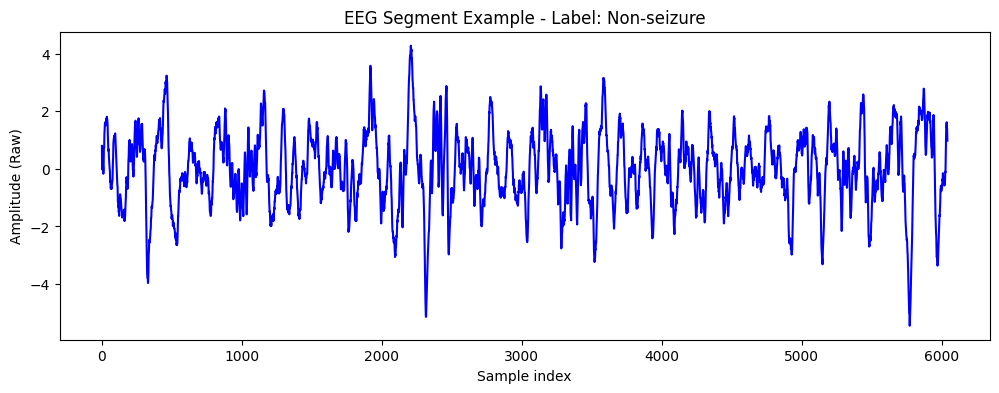

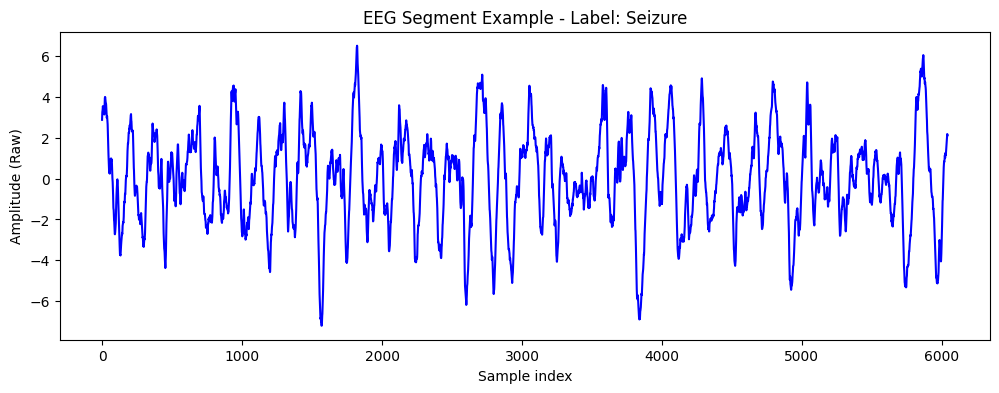

In [186]:
segment = X_val_normalized[0]  
label = y[0]    
plot_eeg_segment(segment, label, num_samples = 6041, norm= False)


segment = X_val_normalized[74]  
label = y[74]    
plot_eeg_segment(segment, label, num_samples = 6041, norm= False)


In [185]:
import torch
from sklearn.metrics import accuracy_score, balanced_accuracy_score, precision_score, recall_score
from sklearn.metrics import classification_report, confusion_matrix

# Define device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Instantiate model
model = simple_EEG_CNN()

# Load model weights
fold = 5  # Define which fold you want to load
try:
    model.load_state_dict(torch.load(f'best_model_fold{fold}.pth', map_location=device))
    print(f"✅ Model from fold {fold} loaded successfully!")
except FileNotFoundError:
    print(f"⚠️ Warning: best_model_fold{fold}.pth not found. Skipping fold {fold}.")
    # Exit or handle the error appropriately
    raise

# Move model to device and set to evaluation mode
model = model.to(device)
model.eval()

import numpy as np

# Z-normalize the validation data independently
mean = np.mean(X)
std = np.std(X)

# Avoid division by zero
if std == 0:
    std = 1

X_val_normalized = (X - mean) / std

X_val_tensor = torch.FloatTensor(X_val_normalized)
y_val_tensor = torch.LongTensor(y)

# Create TensorDataset
val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

# Create DataLoader
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)

# Evaluation
all_preds = []
all_labels = []

with torch.no_grad():
    for inputs, labels in val_loader:
        inputs = inputs.to(device)
        # labels don't need to be moved to device for sklearn metrics
        
        outputs = model(inputs)
        _, preds = torch.max(outputs, 1)
        
        all_preds.extend(preds.cpu().numpy())
        all_labels.extend(labels.numpy())  # labels are already on CPU

# Calculate metrics
accuracy = accuracy_score(all_labels, all_preds)
balanced_acc = balanced_accuracy_score(all_labels, all_preds)
precision = precision_score(all_labels, all_preds, average='macro', zero_division=0)
recall = recall_score(all_labels, all_preds, average='macro', zero_division=0)

print(f"\n{'='*50}")
print(f"Fold {fold} - Validation Metrics")
print(f"{'='*50}")
print(f"Accuracy: {accuracy:.4f}")
print(f"Balanced Accuracy: {balanced_acc:.4f}")
print(f"Precision (macro): {precision:.4f}")
print(f"Recall (macro): {recall:.4f}")

# Detailed per-class metrics
print(f"\n{'='*50}")
print("Detailed Classification Report:")
print(f"{'='*50}")
print(classification_report(all_labels, all_preds))

# Confusion matrix
print(f"\n{'='*50}")
print("Confusion Matrix:")
print(f"{'='*50}")
print(confusion_matrix(all_labels, all_preds))

✅ Model from fold 5 loaded successfully!

Fold 5 - Validation Metrics
Accuracy: 0.4474
Balanced Accuracy: 0.7181
Precision (macro): 0.5172
Recall (macro): 0.7181

Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.44      0.61       149
           1       0.03      1.00      0.07         3

    accuracy                           0.45       152
   macro avg       0.52      0.72      0.34       152
weighted avg       0.98      0.45      0.60       152


Confusion Matrix:
[[65 84]
 [ 0  3]]
